# Imports

In [ ]:
#change

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import requests
from requests import get
from os import path
from bs4 import BeautifulSoup
import os
import re

import json
import unicodedata

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from typing import Dict, List, Optional, Union, cast
from env import github_token, github_username
from wordcloud import WordCloud

import acquire as ac
import prepare  

# Acquire

#### For this project, you will have to build a dataset yourself. Decide on a list of GitHub repositories to scrape, and write the python code necessary to extract the text of the README file for each page, and the primary language of the repository.

#### Which repositories you use are up to you, but you should include at least 100 repositories in your data set.

In [2]:
url = 'https://github.com/search?o=desc&p={num}&q=OpenCV&s=stars&type=Repositories'
response = requests.get(url)

In [3]:
urls = ac.get_all_urls() 

In [4]:
urls

['opencv/opencv_contrib',
 'spmallick/learnopencv',
 'Ewenwan/MVision',
 'opencv/opencv',
 'Hironsan/BossSensor',
 'PySimpleGUI/PySimpleGUI',
 'openframeworks/openFrameworks',
 'oarriaga/face_classification',
 'vipstone/faceai',
 'CMU-Perceptual-Computing-Lab/openpose',
 'esimov/pigo',
 'bytedeco/javacv',
 'justadudewhohacks/opencv4nodejs',
 'jrosebr1/imutils',
 'nuno-faria/tiler',
 'kelaberetiv/TagUI',
 'bijection/sistine',
 'hybridgroup/gocv',
 'peterbraden/node-opencv',
 'hamuchiwa/AutoRCCar',
 'mapillary/OpenSfM',
 'anandpawara/Real_Time_Image_Animation',
 'amusi/AI-Job-Notes',
 'Roujack/mathAI',
 'soruly/trace.moe',
 'shimat/opencvsharp',
 'HuTianQi/SmartOpenCV',
 'MasteringOpenCV/code',
 'makelove/OpenCV-Python-Tutorial',
 'CodecWang/OpenCV-Python-Tutorial',
 'changwookjun/StudyBook',
 'tebelorg/RPA-Python',
 'kongqw/OpenCVForAndroid',
 'nagadomi/lbpcascade_animeface',
 'abhiTronix/vidgear',
 'ivanseidel/Is-Now-Illegal',
 'opentrack/opentrack',
 'skvark/opencv-python',
 'andrewss

In [5]:
df = pd.read_json('data.json')

In [6]:
# 150 repos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             150 non-null    object
 1   language         144 non-null    object
 2   readme_contents  150 non-null    object
dtypes: object(3)
memory usage: 3.6+ KB


In [7]:
df

,repo,language,readme_contents
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw...."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo..."
...,...,...,...
145,jerry1900/faceRecognition,Python,# faceRecognition\n利用OpenCV、CNN进行人脸识别\n万壑，4978...
146,lixiaoshaxing/MultiMediaLearn,C,# MultiMediaLearn\n多媒体学习：图片处理，音视频处理，相机使用，OpenG...
147,WL-Amigo/waifu2x-converter-cpp,C++,# waifu2x (converter only version)\n\nThis is ...
148,atulapra/Emotion-detection,Python,# Emotion detection using deep learning\n\n## ...


# Prepare

In [8]:
language_count = pd.concat([df.language.value_counts(),
                    df.language.value_counts(normalize=True)], axis=1)
language_count.columns = ['n', 'percent']
language_count

,n,percent
Python,61,0.423611
C++,47,0.326389
Java,7,0.048611
JavaScript,6,0.041667
Jupyter Notebook,5,0.034722
Go,3,0.020833
Objective-C,2,0.013889
C#,2,0.013889
Shell,2,0.013889
PHP,1,0.006944


In [9]:
df['text_cleaned'] = df.readme_contents.apply(prepare.basic_clean)
df['text_tokenized'] = df.text_cleaned.apply(prepare.tokenize)
df['text_lemmatized'] = df.text_tokenized.apply(prepare.lemmatize)
df['text_filtered'] = df.text_lemmatized.apply(prepare.remove_stopwords)
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...


In [10]:
# (a|b)
words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]
# words 

# column name will be words, and the column will contain lists of the words in each doc
df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)

df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor..."
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...,"[p, aligncenter, img, srchttpsrawgithubusercon..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra..."
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...,"[div, aligncenter, img, srcgithublogomainblack..."


# Explore

### What are the most common words in READMEs?   

### Single Most Common Words

In [11]:
python_words = ' '.join(df[df.language=='Python'].text_filtered)
c_plus_plus_words = ' '.join(df[df.language=='C++'].text_filtered)
all_words = ' '.join(df.text_filtered)

python_words = re.sub(r'\s.\s', '', python_words)
c_plus_plus_words = re.sub(r'\s.\s', '', c_plus_plus_words)
all_words = re.sub(r'\s.\s', '', all_words)

In [12]:
python_freq = pd.Series(python_words.split()).value_counts()
c_plus_plus_freq = pd.Series(c_plus_plus_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()

all_freq.head()

&#9;      925
image     887
opencv    765
build     498
using     447
dtype: int64

In [13]:
word_counts = (pd.concat([all_freq, python_freq, c_plus_plus_freq], axis=1, sort=True)
               .set_axis(['All', 'Python', 'C++'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.sort_values(by='All', ascending=False).head(10)

,All,Python,C++
&#9;,925,105,534
image,887,600,153
opencv,765,156,244
build,498,25,222
using,447,156,138
file,394,172,79
tdtd,383,383,0
install,376,112,77
use,350,113,135
python,346,227,44


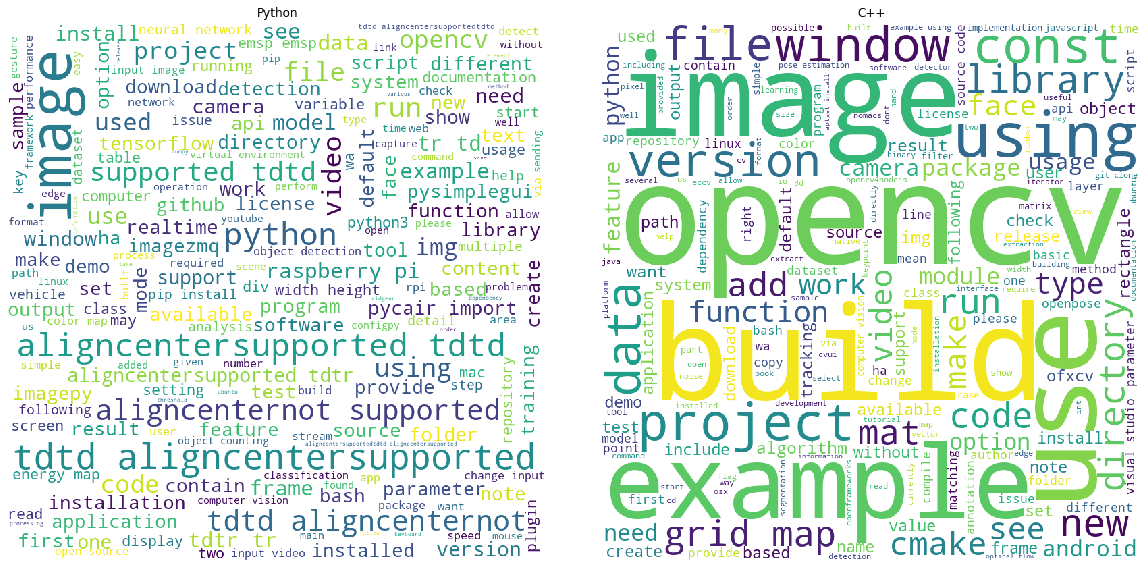

In [14]:
python_cloud = WordCloud(background_color='white',
                      height=800, width=800).generate(python_words)

c_plus_plus_cloud = WordCloud(background_color='white', 
                      height=800, width=800).generate(c_plus_plus_words)

plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(python_cloud)
axs[1].imshow(c_plus_plus_cloud)

axs[0].set_title('Python')
axs[1].set_title('C++')

for ax in axs: ax.axis('off')

### Most Common Bigrams

In [15]:
df['bigrams'] = [list(nltk.ngrams(wordlist, 2)) for wordlist in df.words]
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,bigrams
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz...","[(mvision, machine), (machine, vision), (visio..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor...","[(repository, opencvs), (opencvs, extra), (ext..."
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...,"[p, aligncenter, img, srchttpsrawgithubusercon...","[(p, aligncenter), (aligncenter, img), (img, s..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra...","[(opencv, open), (open, source), (source, comp..."
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...,"[div, aligncenter, img, srcgithublogomainblack...","[(div, aligncenter), (aligncenter, img), (img,..."


In [16]:
python_bigrams = pd.Series(list(nltk.ngrams(python_words.split(), 2))).value_counts().head(20) 
c_plus_plus_bigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 2))).value_counts().head(20)

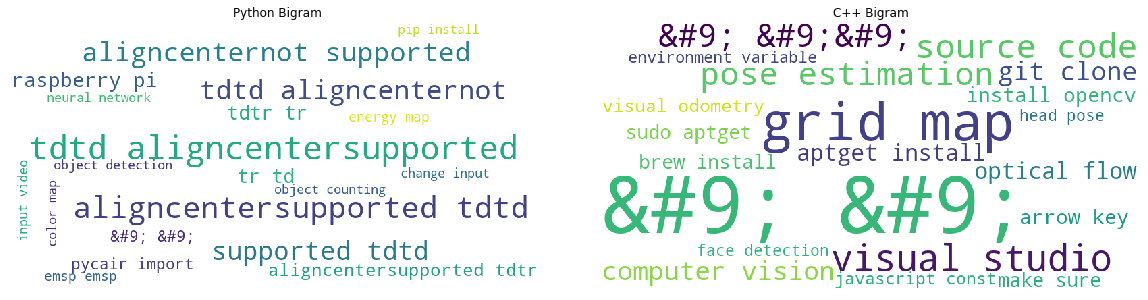

In [17]:
python_data = {k[0] + ' ' + k[1]: v for k, v in python_bigrams.to_dict().items()}
c_plus_plus_data = {k[0] + ' ' + k[1]: v for k, v in c_plus_plus_bigrams.to_dict().items()}

python_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_data)

c_plus_plus_bigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_data)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_bigram_cloud)
axs[1].imshow(c_plus_plus_bigram_cloud)

axs[0].set_title('Python Bigram')
axs[1].set_title('C++ Bigram')

for ax in axs: ax.axis('off')

### Most Common Trigrams

In [19]:
df['trigrams'] = [list(nltk.ngrams(wordlist, 3)) for wordlist in df.words]
df.head()

,repo,language,readme_contents,text_cleaned,text_tokenized,text_lemmatized,text_filtered,words,bigrams,trigrams
0,Ewenwan/MVision,C++,# MVision Machine Vision 机器视觉\n[AI算法工程师手册 数学基础...,mvision machine vision \nai httpwwwhuaxia...,mvision machine vision \nai httpwwwhuaxiaozhua...,mvision machine vision ai httpwwwhuaxiaozhuanc...,mvision machine vision ai httpwwwhuaxiaozhuanc...,"[mvision, machine, vision, ai, httpwwwhuaxiaoz...","[(mvision, machine), (machine, vision), (visio...","[(mvision, machine, vision), (machine, vision,..."
1,opencv/opencv_contrib,C++,## Repository for OpenCV's extra modules\n\nTh...,repository for opencvs extra modules\n\nthis ...,repository for opencvs extra modules\n\nthis r...,repository for opencvs extra module this repos...,repository opencvs extra module repository int...,"[repository, opencvs, extra, module, repositor...","[(repository, opencvs), (opencvs, extra), (ext...","[(repository, opencvs, extra), (opencvs, extra..."
2,PySimpleGUI/PySimpleGUI,Python,"\n<p align=""center"">\n <img src=""https://raw....",\np aligncenter\n img srchttpsrawgithubuserco...,p aligncenter\n img srchttpsrawgithubuserconte...,p aligncenter img srchttpsrawgithubusercontent...,p aligncenter img srchttpsrawgithubusercontent...,"[p, aligncenter, img, srchttpsrawgithubusercon...","[(p, aligncenter), (aligncenter, img), (img, s...","[(p, aligncenter, img), (aligncenter, img, src..."
3,opencv/opencv,C++,## OpenCV: Open Source Computer Vision Library...,opencv open source computer vision library\n\...,opencv open source computer vision library\n\n...,opencv open source computer vision library res...,opencv open source computer vision library res...,"[opencv, open, source, computer, vision, libra...","[(opencv, open), (open, source), (source, comp...","[(opencv, open, source), (open, source, comput..."
4,CMU-Perceptual-Computing-Lab/openpose,C++,"<div align=""center"">\n <img src="".github/Lo...",div aligncenter\n img srcgithublogo_main_bl...,div aligncenter\n img srcgithublogo_main_black...,div aligncenter img srcgithublogo_main_blackpn...,div aligncenter img srcgithublogo_main_blackpn...,"[div, aligncenter, img, srcgithublogomainblack...","[(div, aligncenter), (aligncenter, img), (img,...","[(div, aligncenter, img), (aligncenter, img, s..."


In [20]:
python_trigrams = pd.Series(list(nltk.ngrams(python_words.split(), 3))).value_counts().head(20)
c_plus_plus_trigrams = pd.Series(list(nltk.ngrams(c_plus_plus_words.split(), 3))).value_counts().head(20)

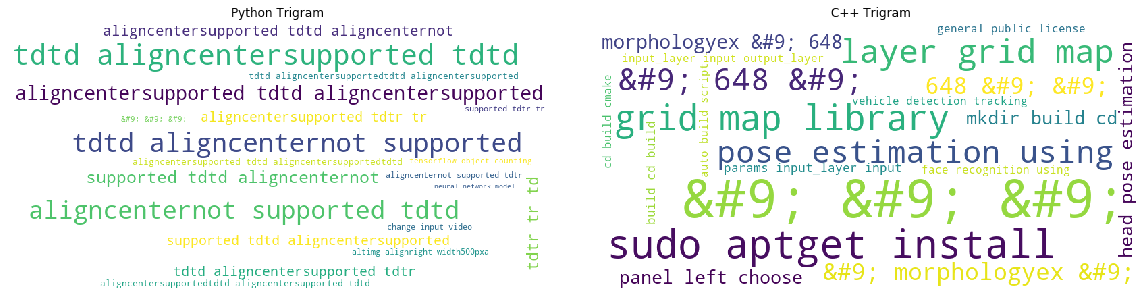

In [23]:
python_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in python_trigrams.to_dict().items()}
c_plus_plus_tridata = {k[0] + ' ' + k[1]+ ' ' + k[2]: v for k, v in c_plus_plus_trigrams.to_dict().items()}

python_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(python_tridata)

c_plus_plus_trigram_cloud = WordCloud(background_color='white', 
                width=800, height=400).generate_from_frequencies(c_plus_plus_tridata)


plt.figure(figsize=(15,15))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

axs[0].imshow(python_trigram_cloud)
axs[1].imshow(c_plus_plus_trigram_cloud)

axs[0].set_title('Python Trigram')
axs[1].set_title('C++ Trigram')

for ax in axs: ax.axis('off')

### What does the distribution of IDFs look like for the most common words?  

### Does the length of the README vary by programming language?    

### Do different programming languages use a different number of unique words?

# Model

- Transform your documents into a form that can be used in a machine learning model. You should use the programming language of the repository as the label to predict.  


- Try fitting several different models and using several different representations of the text (e.g. a simple bag of words, then also the TF-IDF values for each).   


- Build a function that will take in the text of a README file, and tries to predict the programming language.  

### Bag of Words

### TF-IDF

# Conclusion/Takeaways

- Even though OpenCV is primarly written in C++, words repos are written in Python